In [1]:
import pandas as pd 
import numpy as np 
from preprocessing import preprocess
from predictors import log_reg, log_reg_regularized, NN 
from analysis import metrics, plot_roc, predictions, combined_probs
from seaborn import countplot
import matplotlib.pyplot as plt

# First look at the data  
Data is subset of the Adult Census Income dataset, variable 'above' indicates whether annual income exceeds 50K dollars

In [2]:
data_frame = pd.read_csv('Team_Project_doc_data_19/train_test_2019.csv', delimiter=',', header =  0)
data_frame

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,above
0,18,Private,39302,12th,8,Never-married,Other-service,Own-child,White,Female,0,0,12,United-States,no
1,63,Local-gov,241404,Some-college,10,Divorced,Protective-serv,Not-in-family,White,Female,0,0,35,United-States,no
2,38,Self-emp-inc,312232,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,55,United-States,yes
3,52,Local-gov,230095,Some-college,10,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,40,United-States,no
4,27,Private,212895,Some-college,10,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,55,Private,199212,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,5178,0,40,United-States,yes
9996,26,Private,210521,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,42,United-States,yes
9997,44,Federal-gov,210492,Some-college,10,Divorced,Adm-clerical,Unmarried,Black,Male,0,0,40,United-States,no
9998,19,Private,78374,Some-college,10,Never-married,Adm-clerical,Unmarried,Asian-Pac-Islander,Female,0,0,40,United-States,no


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e3e6f10>]],
      dtype=object)

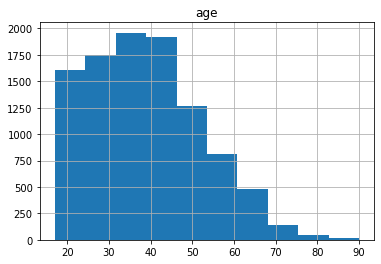

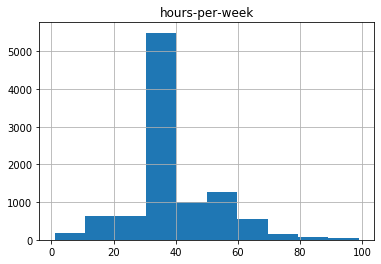

In [3]:
data_frame.hist(column = ['age'])
data_frame.hist(column = ['hours-per-week'])

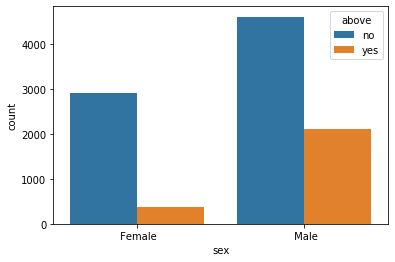

In [4]:
countplot(x="sex", hue = 'above', data=data_frame);

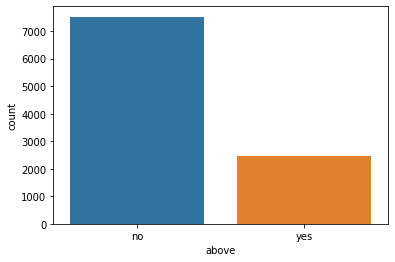

In [5]:
countplot(x = 'above', data = data_frame)

# Preprocessing 
Includes one hot encoding categorical variables and creating train/validation split. 

In [6]:
(X_train, Y_train, X_val, Y_val) = preprocess(data_frame, output_col = -1)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(8000, 103)
(8000,)
(2000, 103)
(2000,)


/Users/rasmushelander/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# Analysis
Using logistic regression with and without regularized weights, as well as a simple neural network with dropout layers. Metrics analyzed are the confusion matrix, precision, recall, f1-score, accuracy, roc-curve and roc auc. 

In [7]:
p_logreg = log_reg(X_train, Y_train, X_val)
res_logreg = metrics(Y_val, p_logreg, cutoff = 0.5)
for (k,v) in res_logreg.items():
    if k != 'roc':
        print(k)
        print(v)       

Optimization terminated successfully.
         Current function value: 0.315719
         Iterations: 529
         Function evaluations: 530
         Gradient evaluations: 530
confusion_matrix
[[1389  118]
 [ 211  282]]
p
0.705
r
0.5720081135902637
f1
0.6315789473684209
acc
0.8355
auc
0.8812021250392018


/Users/rasmushelander/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [8]:
p_logreg_regularized = log_reg_regularized(X_train, Y_train, X_val)
res_logreg_regularized = metrics(Y_val, p_logreg_regularized, cutoff = 0.5)
for (k,v) in res_logreg_regularized.items():
    if k != 'roc':
        print(k)
        print(v)  

/Users/rasmushelander/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


confusion_matrix
[[1394  113]
 [ 208  285]]
p
0.7160804020100503
r
0.5780933062880325
f1
0.6397306397306398
acc
0.8395
auc
0.8876938048404268


In [9]:
from keras import models, layers
model = models.Sequential()
model.add(layers.Dense(50, input_shape=(103,), activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Using TensorFlow backend.


In [10]:
p_nn = NN(X_train, Y_train, X_val, Y_val, model)
res_nn = metrics(Y_val, p_nn, cutoff = 0.5)
p_comb = combined_probs(probs = [p_logreg, p_logreg_regularized, p_nn], accs = [res_logreg['acc'], res_logreg_regularized['acc'], res_nn['acc']], sample_size = len(Y_val))

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 1s 169us/step - loss: 0.4496 - accuracy: 0.7800 - val_loss: 0.3683 - val_accuracy: 0.8225
Epoch 2/30
8000/8000 [==============================] - 1s 85us/step - loss: 0.3717 - accuracy: 0.8224 - val_loss: 0.3581 - val_accuracy: 0.8280
Epoch 3/30
8000/8000 [==============================] - 1s 80us/step - loss: 0.3582 - accuracy: 0.8353 - val_loss: 0.3500 - val_accuracy: 0.8345
Epoch 4/30
8000/8000 [==============================] - 1s 83us/step - loss: 0.3410 - accuracy: 0.8406 - val_loss: 0.3490 - val_accuracy: 0.8395
Epoch 5/30
8000/8000 [==============================] - 1s 86us/step - loss: 0.3348 - accuracy: 0.8466 - val_loss: 0.3466 - val_accuracy: 0.8390
Epoch 6/30
8000/8000 [==============================] - 1s 94us/step - loss: 0.3297 - accuracy: 0.8487 - val_loss: 0.3486 - val_accuracy: 0.8380
Epoch 7/30
8000/8000 [==============================] - 1s 87us/step - loss: 0.32

In [11]:
for (k,v) in res_nn.items():
    if k != 'roc':
        print(k)
        print(v)

confusion_matrix
[[1407  100]
 [ 233  260]]
p
0.7222222222222222
r
0.5273833671399595
f1
0.6096131301289567
acc
0.8335
auc
0.8892410132027551


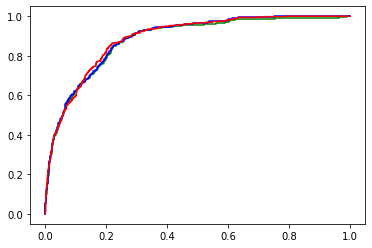

In [12]:
plt.plot(res_logreg['roc'][0], res_logreg['roc'][1], 'g', label = 'logreg')
plt.plot(res_logreg_regularized['roc'][0],res_logreg_regularized['roc'][1], 'b', label = 'logreg_regularided')
plt.plot(res_nn['roc'][0], res_nn['roc'][1], 'r', label = 'nn')